<a href="https://colab.research.google.com/github/leticiafaria7/alura-courses/blob/main/apache-spark/regressao_spark/regressao_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão com Spark
Objetivo: prever preços de imóveis com base nas suas características

## Preparando os dados

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c1176bb242d75bb817b0215cbbc47dea59c5558ee82fcff6356aeeee5d688c3d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
.master('local[*]')\
.appName("Regressão com Spark")\
.getOrCreate()

spark

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

In [5]:
# montar o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[JSON Viewer](https://jsonviewer.stack.hu/)

In [6]:
dados = spark.read.json(
    '/content/drive/MyDrive/5. Cursos/programming/alura-courses/apache-spark/regressao_spark/aula01/imoveis.json'
)

In [7]:
dados.show(truncate = False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [8]:
dados.count()

73615

## Seleção de features

In [9]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [10]:
dados\
.select('ident.customerID', 'listing.*')\
.show(truncate = False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [11]:
dados\
.select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
.show(truncate = False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [12]:
dados\
.select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
.drop('city', 'location', 'totalAreas')\
.show(truncate = False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [13]:
dataset = dados\
.select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
.drop('city', 'location', 'totalAreas')

## Tratamento dos dados

In [14]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [15]:
dataset = dataset\
.withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
.withColumn('price', dataset['price'].cast(DoubleType()))\
.withColumn('condo', dataset['condo'].cast(DoubleType()))\
.withColumn('iptu', dataset['iptu'].cast(DoubleType()))

In [16]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|  iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|   0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|  

In [17]:
dataset\
.select('usage')\
.groupBy('usage')\
.count()\
.show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [18]:
dataset = dataset\
.select('*')\
.where('usage == "Residencial"')

In [19]:
dataset\
.select('unit')\
.groupBy('unit')\
.count()\
.show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [20]:
dataset\
.select('zone')\
.groupBy('zone')\
.count()\
.show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [21]:
# contagem de valores nulos
dataset\
.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
.show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [22]:
dataset\
.select('*')\
.na\
.fill(0)\
.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [23]:
dataset = dataset\
.select('*')\
.na\
.fill(0)

In [24]:
# contagem de valores nulos
dataset\
.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
.show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [25]:
dataset\
.select('zone')\
.groupBy('zone')\
.count()\
.show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [26]:
dataset = dataset\
.where(f.col('zone') != '')

# Regressão Linear

Ciclo de ML

- Seleção de features
- Separação treino e teste
- Criação do modelo
- Ajuste do modelo
- Gerando previsões
- Gerando métricas
- Avaliando métricas
- Melhorando o modelo

## Variáveis dummy

In [27]:
dataset\
.groupBy('customerID')\
.pivot('unit')\
.agg(f.lit(1))\
.na\
.fill(0)\
.show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [28]:
unit = dataset\
.groupBy('customerID')\
.pivot('unit')\
.agg(f.lit(1))\
.na\
.fill(0)

In [29]:
zone = dataset\
.groupBy('customerID')\
.pivot('zone')\
.agg(f.lit(1))\
.na\
.fill(0)

In [30]:
# juntar tudo no dataset

dataset = dataset\
.join(unit, 'customerID', how = 'inner')\
.join(zone, 'customerID', how = 'inner')

In [31]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

## Modelo

In [32]:
# o spark espera que o que a gente quer prever esteja com o nome "label"
dataset = dataset.withColumnRenamed('price', 'label')

In [33]:
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [34]:
# A feature transformer that merges multiple columns into a vector column
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [35]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [36]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [37]:
dataset_prep.show(10, truncate = False)

+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

In [38]:
dataset_prep.count()

69439

In [39]:
dataset.count()

69439

## Exploração dos dados

In [40]:
# passar um dataset vetorizado

correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [41]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

In [42]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [43]:
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [44]:
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [45]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = X, index = X)

In [46]:
dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


<Axes: >

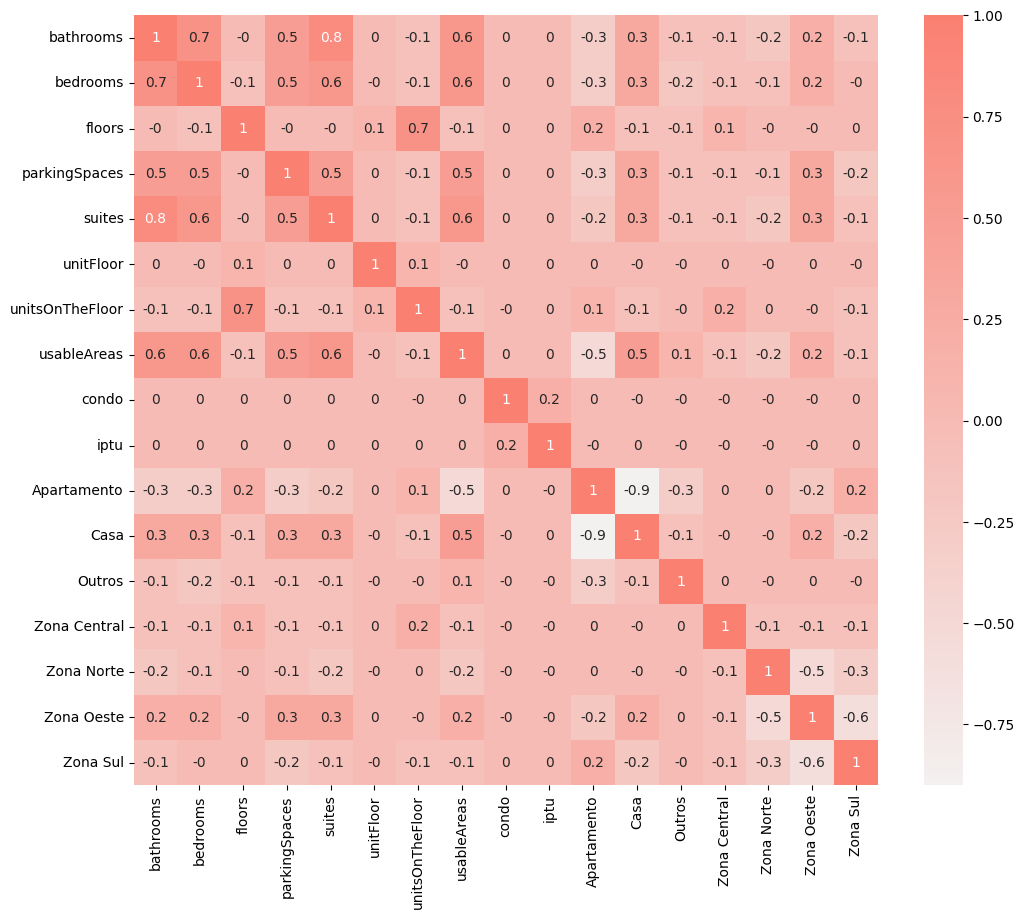

In [47]:
plt.figure(figsize = (12, 10))
paleta = sns.color_palette('light:salmon', as_cmap = True)
sns.heatmap(dataframe_correlacao.round(1), annot = True, cmap = paleta)

**Multicolinearidade**: correlação entre duas variáveis explicativas ou entre uma delas e as demais incluídas na equação de um modelo.

Quando a correlação entre variáveis explicativas é alta, a eficiência dos coeficientes estimados diminui, e a variância da estimativa aumenta

Situação ideal (ausência de multicolinearidade): correlação nula entre variáveis explicativas

A multicolinearidade aumenta os erros padrão dos coeficientes. Quando os erros aumentam, algumas variáveis ficam estatisticamente insignificantes quando deveriam ser significativas

Remover uma das variáveis que apresentem alta correlação entre si (explicam o mesmo comportamento, então são ambíguas)

## Ajuste e previsão

In [48]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed = 101)

In [49]:
treino.count()

48528

In [50]:
teste.count()

20911

In [51]:
lr = LinearRegression()

In [52]:
modelo_lr = lr.fit(treino)

In [53]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [54]:
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

## Métricas

In [55]:
resumo_treino = modelo_lr.summary

In [56]:
resumo_treino.r2

0.6655873678454578

In [57]:
resumo_treino.rootMeanSquaredError

810348.969531623

In [58]:
resumo_teste = modelo_lr.evaluate(teste)

In [59]:
resumo_teste.r2

0.6585207937774393

In [60]:
resumo_teste.rootMeanSquaredError

800525.9696828632

## Tabela resumo regressão linear

In [61]:
print('Linear regression')
print('='*30)
print('Dados de treino')
print('='*30)
print('R²: %f' % resumo_treino.r2)
print('RMSE: %f' % resumo_treino.rootMeanSquaredError)
print('')
print('='*30)
print("Dados de teste")
print('='*30)
print('R²: %f' % resumo_teste.r2)
print('RMSE: %f' % resumo_teste.rootMeanSquaredError)

Linear regression
Dados de treino
R²: 0.665587
RMSE: 810348.969532

Dados de teste
R²: 0.658521
RMSE: 800525.969683


# Árvore de decisão

Estrutura:
- Nó inicial (raiz)
- Ramificações que geram novos nós
- Folhas: nó especial com a informação da resposta

No caso da regressão, a resposta é um valor numérico

Cada ramo representa uma tomada de decisão a partir de um valor ou categoria das variáveis explicativas

Critérios de divisão de nós = variância

O algoritmo faz simulações para a separação dos dados com base em uma variável explicativa e extrai a média da variável alvo em cada nó formado

## Ajuste e previsão

In [62]:
dtr = DecisionTreeRegressor(seed = 101, maxDepth = 7)

In [63]:
modelo_dtr = dtr.fit(treino)

In [65]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [66]:
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

## Avaliador de regressão

[RegressionEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)

In [68]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'rmse'}))

0.7930752588471226
637436.5434260432


In [70]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [72]:
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...| 340000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 430000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 600000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 439000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1180000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1299500.0|1158420.7653661144|
|(17,[0,1,2,

In [73]:
print('Decision Tree Regression')
print('='*30)
print('Dados de treino')
print('='*30)
print('R²: %f' % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'r2'}))
print('RMSE: %f' % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: 'rmse'}))
print('')
print('='*30)
print("Dados de teste")
print('='*30)
print('R²: %f' % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: 'r2'}))
print('RMSE: %f' % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: 'rmse'}))

Decision Tree Regression
Dados de treino
R²: 0.793075
RMSE: 637436.543426

Dados de teste
R²: 0.773813
RMSE: 651518.489921


R² = porcentagem de variação da variável resposta que é explicada pelo modelo de regressão

RMSE = root mean squared error = raiz quadrada do erro médio entre os valores reais e as predições da regressão
Quanto menor o valor, melhor será o modelo

# Random Forest

Aprendizado de ensemble = utiliza diferentes algoritmos combinados para obter a predição mais correta

Bootstrap aggragating
- são extraídos subconjuntos dos dados originais
- são gerados diferentes modelos para cada um dos subconjuntos
- diferenciação entre os resultados obtidos em cada modelo
- amostragem por reposição

Vantagens:
- Mantém uma boa previsão mesmo que haja dados faltantes
- Funciona de forma eficiente mesmo em conjunto de dados grande

Desvantagens:
- Requer mais recursos computacionais (por ser ensemble)
- Demora mais para treinar e prever

## Ajuste e previsão

In [76]:
rfr = RandomForestRegressor(seed = 101, maxDepth = 7, numTrees = 10)

In [77]:
modelo_rfr = rfr.fit(treino)

In [78]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [79]:
previsoes_rfr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|390218.33742322924|
|(17,[0,1,2,3,4,5,...|500000.0| 510060.6595782173|
|(17,[0,1,2,3,4,5,...|308615.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|279000.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|545000.0|  396904.928725379|
|(17,[0,1,2,3,4,5,...|449000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...|479000.0|433807.13396085694|
|(17,[0,1,2,3,4,5,...|420000.0| 664440.4325776277|
|(17,[0,1,2,3,4,5,...|265000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...|490000.0| 816123.0337632223|
|(17,[0,1,2,3,4,5,...|650000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...|379900.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|449000.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|190000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...|896000.0| 547828.3209496561|
|(17,[0,1,2,3,4,5,...|679000.0| 893791.6624292185|
|(17,[0,1,2,3,4,5,...|620000.0|

## Métricas

In [80]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'rmse'}))

0.8017561510914318
623922.4426224458


In [81]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [82]:
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

In [83]:
print('Random Forest Regression')
print('='*30)
print('Dados de treino')
print('='*30)
print('R²: %f' % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'r2'}))
print('RMSE: %f' % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'rmse'}))
print('')
print('='*30)
print("Dados de teste")
print('='*30)
print('R²: %f' % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: 'r2'}))
print('RMSE: %f' % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: 'rmse'}))

Random Forest Regression
Dados de treino
R²: 0.801756
RMSE: 623922.442622

Dados de teste
R²: 0.790530
RMSE: 626981.467738
